In [1]:
## import os
import pandas as pd
import numpy as np
import math
from itertools import cycle
import tensorflow as tf
#tf.enable_eager_execution()
import efficientnet.tfkeras as efn

In [2]:
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='albertv3')
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system: albertv3
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.240.1.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13222386740685493855)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14296830844354023676)
INFO:tensor

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# hyperparameters
NUM_EPOCHS = 250
LEARNING_RATE = 0.001
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL = 16


# default size of EfficientNet
IMG_SIZE = (224, 224)

GCS_OUTPUT = 'gs://tpuv3/bone-age/tfrecords-jpeg-224x224/bone'  # prefix for output file names

In [5]:
core_idg = ImageDataGenerator(zoom_range=0.2,
                              fill_mode='nearest',
                              featurewise_center=False,  # set input mean to 0 over the dataset
                              samplewise_center=False,  # set each sample mean to 0
                              featurewise_std_normalization=False,  # divide inputs by std of the dataset
                              samplewise_std_normalization=False,  # divide each input by its std
                              zca_whitening=False,  # apply ZCA whitening
                              rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
                              width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,  # randomly flip images
                              vertical_flip=False)

val_idg = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True)

In [17]:
train_df_boneage, valid_df_boneage = train_test_split(boneage_df, test_size=0.1,
                                                      random_state=24)  # ,stratify=boneage_df['boneage_category'])
print('train', train_df_boneage.shape[0], 'validation', valid_df_boneage.shape[0])

train 10214 validation 1135


In [41]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    """
    Creates a DirectoryIterator from in_df at path_col with image preprocessing defined by img_data_gen. The labels
    are specified by y_col.
    :param img_data_gen: an ImageDataGenerator
    :param in_df: a DataFrame with images
    :param path_col: name of column in in_df for path
    :param y_col: name of column in in_df for y values/labels
    :param dflow_args: additional arguments to flow_from_directory
    :return: df_gen (keras.preprocessing.image.DirectoryIterator)
    """
    print('flow_from_dataframe() -->')
    base_dir = os.path.dirname(os.path.dirname(in_df[path_col].values[0]))
    #base_dir = 'rsna-bone-age/images'
    print(base_dir)
    print('## Ignore next message from keras, values are replaced anyways')
    # flow_from_directory: Takes the path to a directory, and generates batches of augmented/normalized data.
    # sparse: a 1D integer label array is returned
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    # df_gen: A DirectoryIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images
    # with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.
    df_gen.filenames = in_df[path_col].values
    #df_gen.filepaths = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = base_dir  # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    print('flow_from_dataframe() <--')
    return df_gen

In [50]:
train_gen_boneage = flow_from_dataframe(core_idg, train_df_boneage, path_col='path', y_col=class_str_col,
                                        target_size=IMG_SIZE,
                                        color_mode='rgb', batch_size=BATCH_SIZE_TRAIN)

# used a fixed dataset for evaluating the algorithm
valid_gen_boneage = flow_from_dataframe(core_idg, valid_df_boneage, path_col='path', y_col=class_str_col,
                                        target_size=IMG_SIZE,
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE_VAL)  # we can use much larger batches for evaluation

flow_from_dataframe() -->
rsna-bone-age/images
## Ignore next message from keras, values are replaced anyways
Found 12612 images belonging to 2 classes.
Reinserting dataframe: 10214 images
flow_from_dataframe() <--
flow_from_dataframe() -->
rsna-bone-age/images
## Ignore next message from keras, values are replaced anyways
Found 12612 images belonging to 2 classes.
Reinserting dataframe: 1135 images
flow_from_dataframe() <--


In [64]:
def combined_generators(image_generator, gender_data, batch_size):
    gender_generator = cycle(batch(gender_data, batch_size))
    while True:
        nextImage = next(image_generator)
        nextGender = next(gender_generator)
        assert len(nextImage[0]) == len(nextGender)
        yield [nextImage[0], nextGender], nextImage[1]


def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


train_gen_wrapper = combined_generators(train_gen_boneage, train_df_boneage[gender_str_col], BATCH_SIZE_TRAIN)
val_gen_wrapper = combined_generators(valid_gen_boneage, valid_df_boneage[gender_str_col], BATCH_SIZE_VAL)
print('batch size: ', BATCH_SIZE_TRAIN)

batch size:  16


In [4]:
GCS_PATTERN = 'gs://tpuv3/bone-age/tfrecords-jpeg-224x224/*.tfrec'
BATCH_SIZE = 16  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.

VALIDATION_SPLIT = 0.19

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
#random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(11349 // len(filenames) * len(validation_filenames)) // BATCH_SIZE  # 11349 is the numer of images in the dataset
steps_per_epoch = int(11349 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 16, there will be 576 batches per training epoch and 132 batch(es) per validation run.


In [6]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, sexes in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      numpy_sexes = sexes.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels, numpy_sexes = ses.run(get_next_item)

  return numpy_images, numpy_labels, numpy_sexes

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels, sexes = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = str(labels[i]) + ' - ' + str(sexes[i])
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

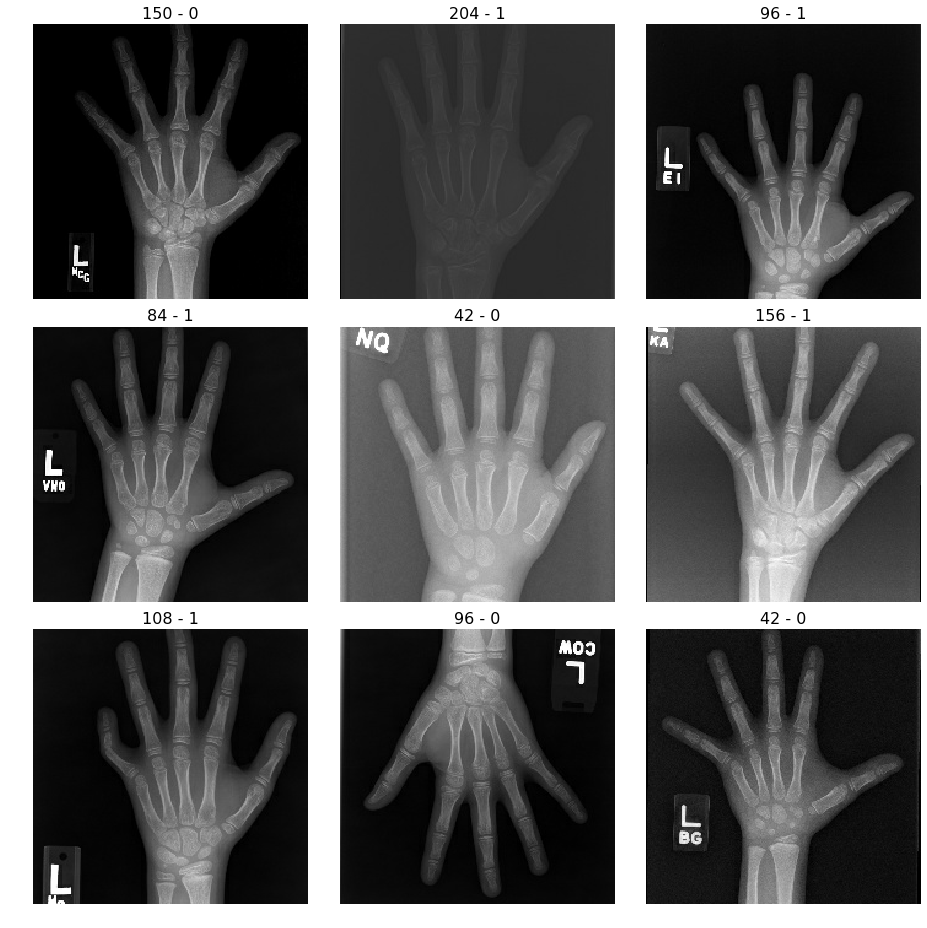

In [72]:
display_9_images_from_dataset(load_dataset(training_filenames))

In [6]:
print('==================================================')
print('================= Building Model =================')
print('==================================================')
from tensorflow.keras.applications.resnet50 import ResNet50
#with strategy.scope():
AUTO = tf.data.experimental.AUTOTUNE
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "sex": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMG_SIZE, 3]) # explicit size will be needed for TPU
    label = tf.cast(example['label'], tf.int32)
    sex = tf.cast(example['sex'], tf.int32)
    return image, label, sex

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(option_no_order)
    #dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)

    if tf.executing_eagerly():
        # In eager mode, iterate in the Datset directly.
        for images, labels, sexes in dataset:
            numpy_images = images.numpy()
            numpy_labels = labels.numpy()
            numpy_sexes = sexes.numpy()
            break;

    else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
        get_next_item = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as ses:
          numpy_images, numpy_labels, numpy_sexes = ses.run(get_next_item)

    return numpy_images, numpy_labels, numpy_sexes

def box(image, label, sex):
    return [image, sex], label

def data_augment(image, label, sex):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label, sex

def get_batched_dataset(filenames, augment_data):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    if augment_data:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(box, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder will be needed on TPU
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # For proper ordering of map/batch/repeat/prefetch, see Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
    return dataset

def get_training_dataset():
    return get_batched_dataset(training_filenames, augment_data=True)

def get_validation_dataset():
    return get_batched_dataset(validation_filenames, augment_data=False)

#some_bones, some_labels, some_sexes = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

i1 = Input(shape=(224, 224, 3), name='input_img')
i2 = Input(shape=(1,), name='input_gender')
base = ResNet50(input_tensor=i1, input_shape=(224, 224, 3), include_top=False, weights='imagenet')
#base = efn.EfficientNetB0(input_tensor=i1, input_shape=(224, 224, 3), include_top=False, weights='imagenet')

feature_img = base.get_layer(name='conv5_block3_out').output
#feature_img = base.get_layer(name='top_activation').output
feature_img = AveragePooling2D((2, 2))(feature_img)
feature_img = Flatten()(feature_img)
feature_gender = Dense(32, activation='relu')(i2)
feature = concatenate([feature_img, feature_gender], axis=1)

# feature = feature_img
o = Dense(1000, activation='relu')(feature)
o = Dense(1000, activation='relu')(o)
o = Dense(1)(o)
model = Model(inputs=[i1, i2], outputs=o)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

#model.summary()

weight_path = "{}_weights.best.hdf5".format('bone_age')

#checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min')

#early = EarlyStopping(monitor="val_loss", mode="min",patience=10)

#reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=15, verbose=1,save_best_only=True, mode='auto', epsilon=0.0001, cooldown=5)

tpu = tf.contrib.cluster_resolver.TPUClusterResolver('albertv3')
strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

history = tpu_model.fit(get_training_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS,
                      validation_data=get_validation_dataset, validation_steps=validation_steps)

model.save('saved_model.h5')

print('Model Saved ! :) \n')

print('Boneage dataset (final): val_mean_absolute_error: ', history.history['val_mean_absolute_error'][-1])

================= Building Model =================
INFO:tensorflow:Querying Tensorflow master (grpc://10.240.1.18:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13222386740685493855)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14296830844354023676)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12871516790933191222)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11344936028634108978)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 4992140335721786025)
INFO:tensorf

AttributeError: 'Model' object has no attribute 'target_tensors'